# Planejamento da solução

## Input

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização


2. Questões que serão respondidas
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?


3. Fonte de dados
    - Vendas de um e-commerce online, o periodo de um ano.

## Output

1. A indicação das pessoas que farão parte do programe de Insiders
    - Lista: cliente_id | is_insider
                10234   |    yes
                10235   |    no
                
2. Relatório com as respostas das perguntass de negócio.

## Task

## Desk Research

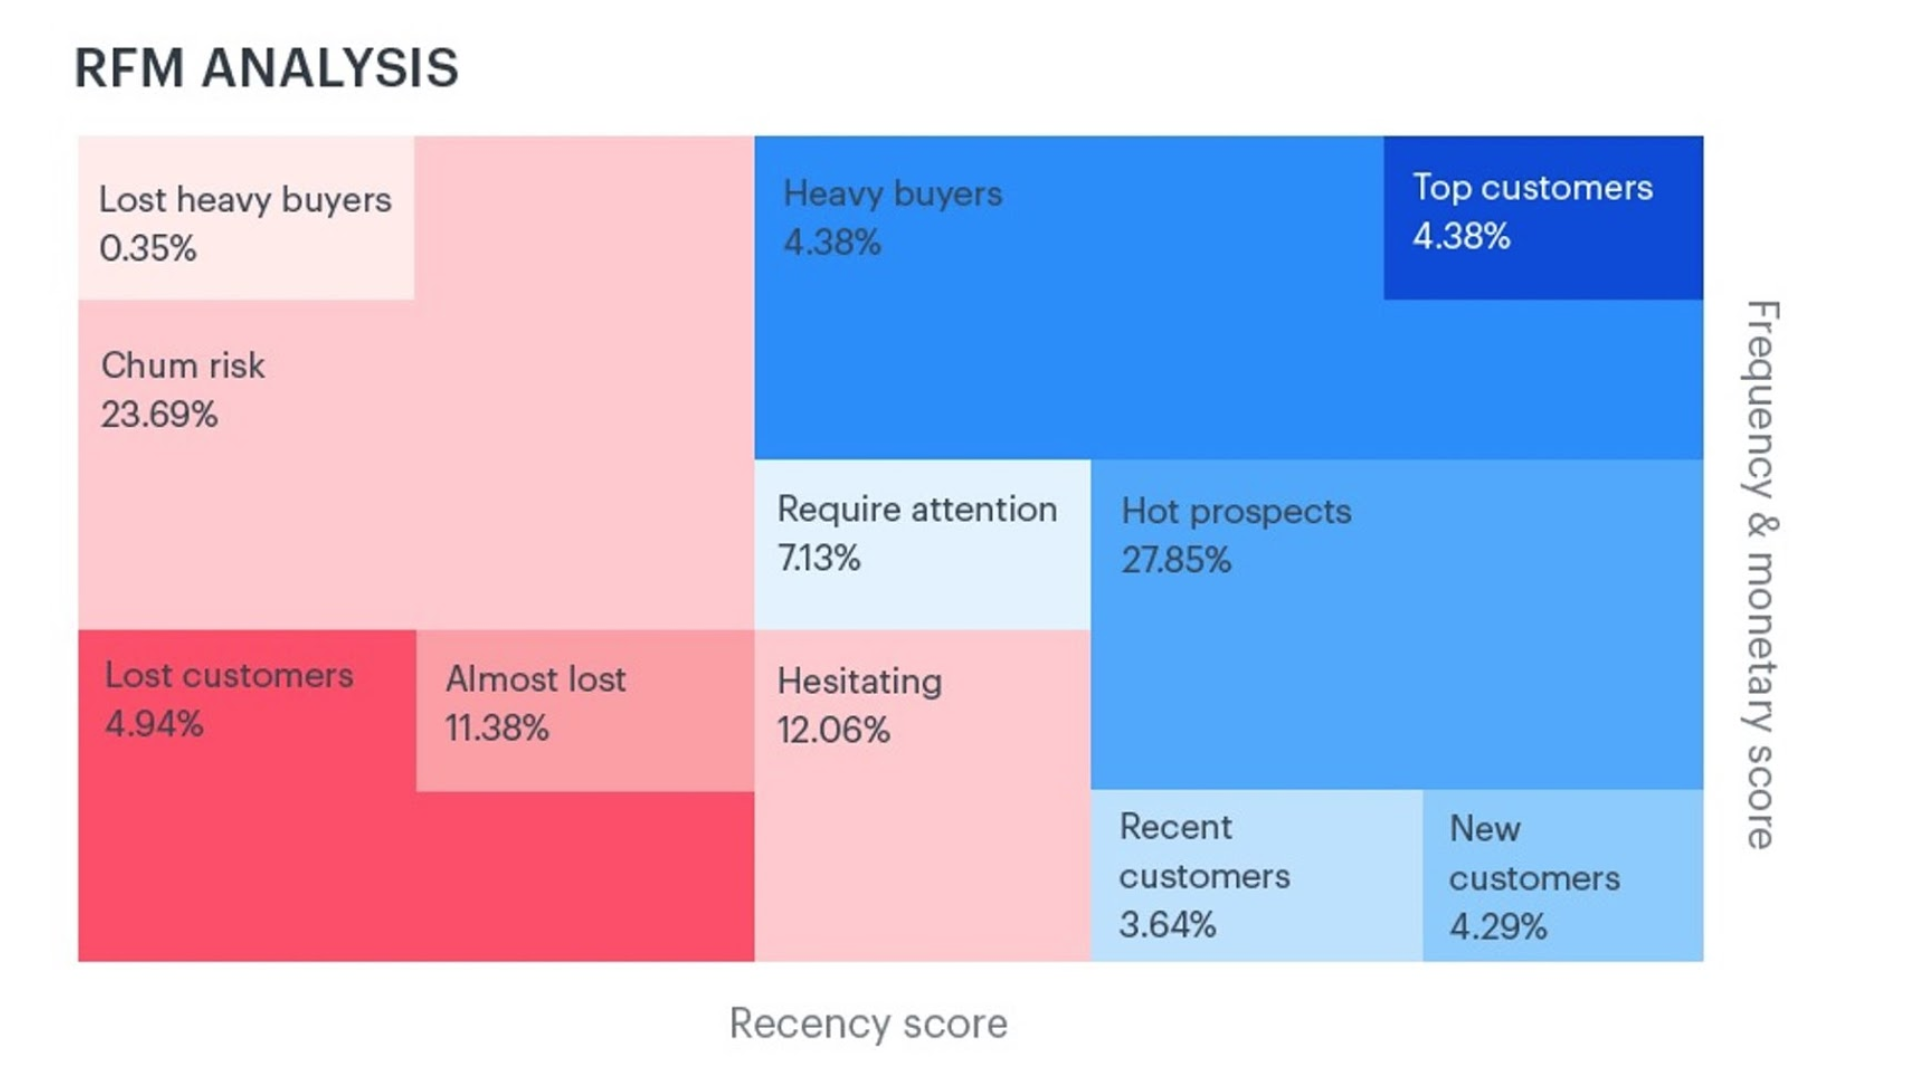

# Imports

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

import umap.umap_ as umap

import re

from sklearn import preprocessing as pp

## Helper Functions

In [87]:
# Notebook configuration
display( HTML( '<style>.container { width:95% !important; }</style>') )

## Load Dataset

In [88]:
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='iso-8859-1')

# drop extra colum
df_raw = df_raw.drop(columns='Unnamed: 8')

# Data Cleaning & Data Description

In [89]:
# save pickle
pickle.dump(df_raw, open('../src/steps/df1.pkl', 'wb'))

# load pickle
df1 = pickle.load(open('../src/steps/df1.pkl', 'rb'))

## Rename Columns

In [90]:
# ordering columns
df1 = df1[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

# rename columns
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

## Data Dimensions

In [91]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 541909
Number of Cols: 8


## Data Types

In [92]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Check NA

In [93]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### Drop NA

In [94]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print(f'Removed data: {(1 - (df1.shape[0] / df_raw.shape[0])) * 100:.2f}%')

Removed data: 24.93%


In [95]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## Change dtypes

In [96]:
# [invoice_date] - change from object to datetime format
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# [customer_id] - verify if there are float values in the column, if not, change the format to int64
if [print(i) for i in df1['customer_id'] if i.is_integer() == False] == []:
    df1['customer_id'] = df1['customer_id'].astype('int64')

## Descriptive Statistics

In [97]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [98]:
# central tendency metrics
mean_     = pd.DataFrame(num_attributes.mean()).T
median_   = pd.DataFrame(num_attributes.median()).T

# dispersion metrics
min_      = pd.DataFrame(num_attributes.min()).T
max_      = pd.DataFrame(num_attributes.max()).T
range_    = pd.DataFrame(num_attributes.max() - num_attributes.min()).T
std_      = pd.DataFrame(num_attributes.std()).T
skew_     = pd.DataFrame(num_attributes.skew()).T
kurtosis_ = pd.DataFrame(num_attributes.kurtosis()).T


metrics = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis',  ]
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693370,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315162,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.600303,0.029835,-1.179982


#### <font color='red'> Numerical Attributes - Investigating </font>

1. Negative quantity ( can be return )
2. Preço unitario igual a 0 ( pode ser promoção )

### Categorical Attributes

#### <font color='red'> Categorical Attributes - Investigating </font>

##### Invoice_no

In [99]:
# invoice_no with words
invoice_no_with_words = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x ))), :]

print(f'Exists {len(invoice_no_with_words["invoice_no"].unique())} unique invoice_no with words')
print(f'Exists {len(invoice_no_with_words)} invoice_no with words')
print(f'Exists {len(invoice_no_with_words[invoice_no_with_words["quantity"] < 0])} invoice_no with words and negative quantity')

Exists 3654 unique invoice_no with words
Exists 8905 invoice_no with words
Exists 8905 invoice_no with words and negative quantity


##### stock_code

In [100]:
# stock_code with letters
stock_code_with_letters = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

# stock_code only with letters
stock_code_only_with_letters = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]


print(f'Exists {len(stock_code_with_letters["stock_code"].unique())} unique stock_code with letters')
print(f'Exists {len(stock_code_with_letters["stock_code"])} stock_code with letters')
print(100 * '-')
print(f'Exists 6 types of stock_code only with letters: {stock_code_only_with_letters["stock_code"].unique()}')
print(f'Exists {len(stock_code_only_with_letters["stock_code"])} stock_code only with letters')

# action: remove stock_code in ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']

Exists 886 unique stock_code with letters
Exists 35809 stock_code with letters
----------------------------------------------------------------------------------------------------
Exists 6 types of stock_code only with letters: ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']
Exists 1774 stock_code only with letters


##### description

In [101]:
# action: delete feature 

##### country

In [102]:
df1["country"].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [103]:
print(f'Exists {len(df1["country"].unique())} countries in the dataset')

Exists 37 countries in the dataset


In [104]:
# percentage of each country in the dataset
pd.DataFrame(df1['country'].value_counts(normalize=True)).head()

,country
United Kingdom,0.889509
Germany,0.023339
France,0.020871
EIRE,0.018398
Spain,0.006226


In [105]:
# quantity of customers by country in the dataset
df1[['country', 'customer_id']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# Data Filtering

In [106]:
# save pickle
pickle.dump(df1, open('../src/steps/df2.pkl', 'wb'))

# load pickle
df2 = pickle.load(open('../src/steps/df2.pkl', 'rb'))

In [107]:
# unit_price - remove unit price under 0.05 cents
df2 = df2[df2['unit_price'] > 0.04]

# stock_code - remove stock codes only with letters
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

# description - remove description column
df2 = df2.drop(columns='description')

# country - remove 'European Community' and 'Unspecified' values because they are unidentifiable
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity - divide dataset into two datasets (returns and purchases)
df2_return = df2[df2['quantity'] < 0]
df2_purchase = df2[df2['quantity'] > 0]

# Feature Engineering

In [108]:
# save pickle
pickle.dump(df2, open('../src/steps/df3.pkl', 'wb'))

# load pickle
df3 = pickle.load(open('../src/steps/df3.pkl', 'rb'))

## Feature Creation

In [109]:
# data reference
df_ref = pd.DataFrame(df3['customer_id']).drop_duplicates(ignore_index=True)

In [110]:
# Gross Revenue of purchase: quantity * unit_price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# calculate de total revenue per customer
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# merge df_ref with df_monetary
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

C:\Users\victo\AppData\Local\Temp\ipykernel_332\3839311384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    27
dtype: int64

In [111]:
# # Recency: number of days since last purchase 
# obtain the last purchase date of each customer 
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# calculate the number of days since last purchase (use last purchase on dataset as 'today')
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days

# merge df_ref with recency days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [112]:
# Frequency: total purchases made by each customers

# obtain the quantity of purchase by customer
df_frequency = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_frequency = df_frequency.rename(columns={'invoice_no': 'frequency'})

# merge df_ref with frequency
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
frequency        27
dtype: int64

In [113]:
# Avg Ticket: mean of gross revenue for each customer
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})

# merge df_ref with avg ticket
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
frequency        27
avg_ticket       27
dtype: int64

The NAs are because there are 27 clients in the original dataset (df_ref contains the unique ids) that do not have purchase records, only returns, so when we try to merge the NAs are generated.

In [114]:
# drop NAs
df_ref = df_ref.dropna()

## Features Description

**gross_revenue:** Total billing per customer (without considering returns).

**recency_days:** Number of days since last purchase (without considering returns).

**frequency:** Total purchases made by each customers (without considering returns).

**avg_ticket:** Average ticket of all purchases made by each customer

# Exploratory Data Analysis

In [115]:
# save pickle
pickle.dump(df_ref, open('../src/steps/df4.pkl', 'wb'))

# load pickle
df4 = pickle.load(open('../src/steps/df4.pkl', 'rb'))

# Data Preparation

In [159]:
# save pickle
pickle.dump(df4, open('../src/steps/df5.pkl', 'wb'))

# load pickle
df5 = pickle.load(open('../src/steps/df5.pkl', 'rb'))

In [160]:
# # Standard Scaler
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

# Feature Selection

In [161]:
# save pickle
pickle.dump(df5, open('../src/steps/df6.pkl', 'wb'))

# load pickle
df6 = pickle.load(open('../src/steps/df6.pkl', 'rb'))

# Machine Learning

In [162]:
# save pickle
pickle.dump(df6, open('../src/steps/df7.pkl', 'wb'))

# load pickle
df7 = pickle.load(open('../src/steps/df7.pkl', 'rb'))

## Hyperparameter Fine Tuning

In [163]:
# remove customer id column
x = df7.drop(columns=['customer_id'])

In [164]:
clusters = [2, 3, 4, 5, 6, 7]

### Within-Cluster Sum of Square (WSS)

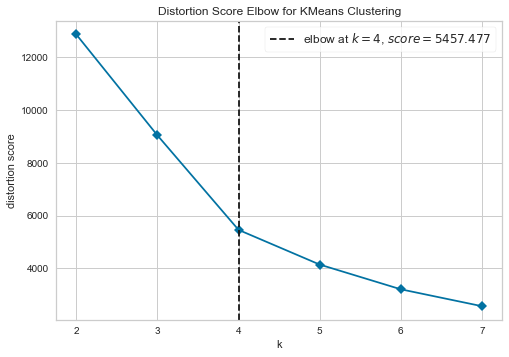

In [165]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(x)
kmeans.show();

### Silhouette Score

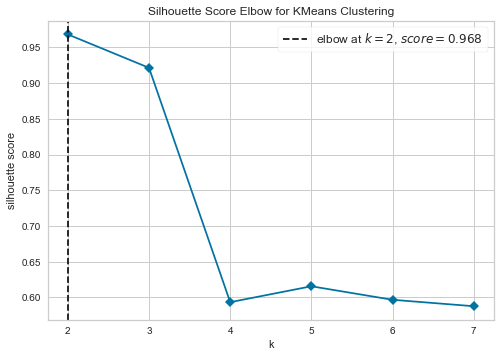

In [166]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(x)
kmeans.show();

### Silhouette Analysis

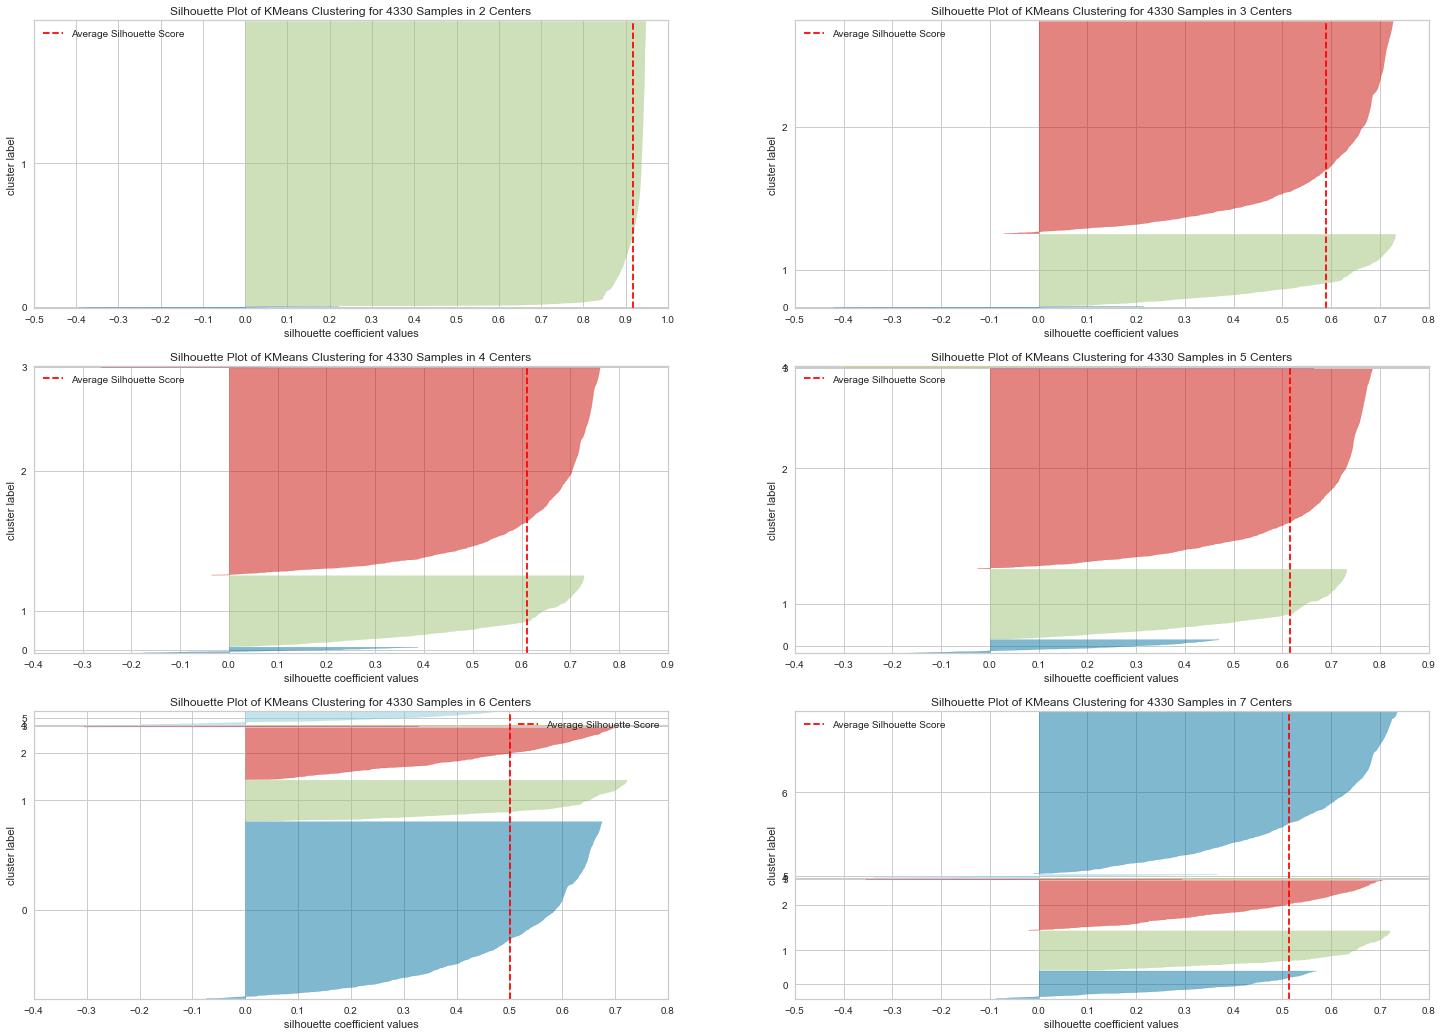

In [167]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(3, 2, figsize=(25, 18))
for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x);
    visualizer.finalize();

## Model Training

### K-Means

In [174]:
# model definition
k = 3
kmeans = c.KMeans(init = 'random',
                  n_clusters = k,
                  n_init = 10,
                  max_iter = 300,
                  random_state = 42)

# model training
kmeans.fit(x)

# clustering
labels = kmeans.labels_

#### Cluster Validation

In [175]:
# WSS
print(f'WSS value: {kmeans.inertia_}')

# SS
print(f'SS value: {m.silhouette_score(x, labels, metric="euclidean")}')

WSS value: 9404.95792327029
SS value: 0.5895242294229587


# Cluster Analysis

In [176]:
# save pickle
pickle.dump(df7, open('../src/steps/df8.pkl', 'wb'))

# load pickle
df8 = pickle.load(open('../src/steps/df8.pkl', 'rb'))

# add clustering labels
df8['cluster'] = labels

## Visualization Inspection

### Silhouette Score

c:\users\victo\repos\insiders_clustering\insiders-venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


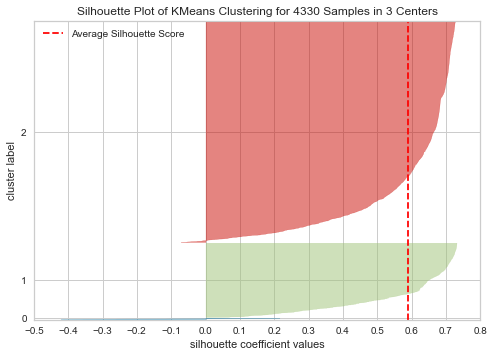

In [177]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(x)
visualizer.finalize();

### 2D Plot

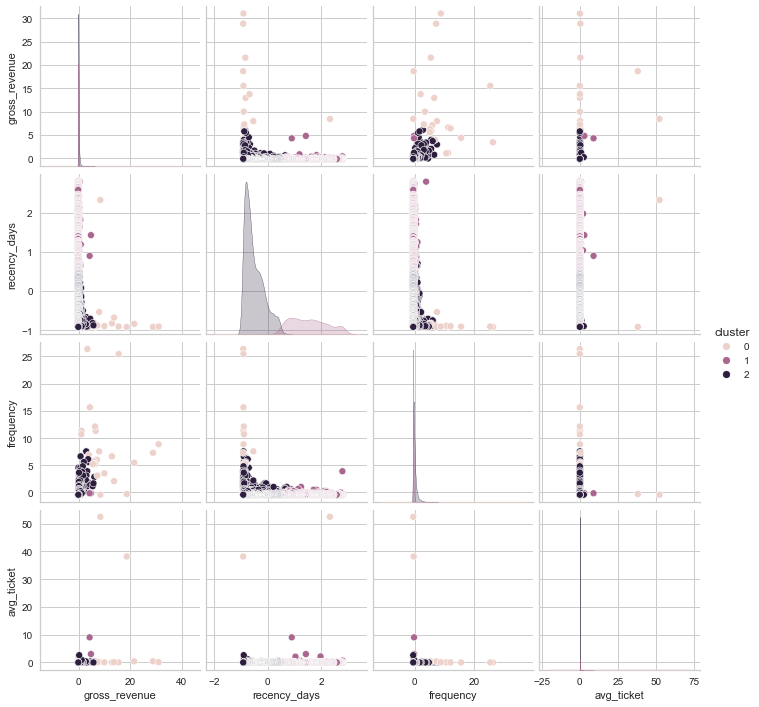

In [178]:
df_viz = df8.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

### UMAP

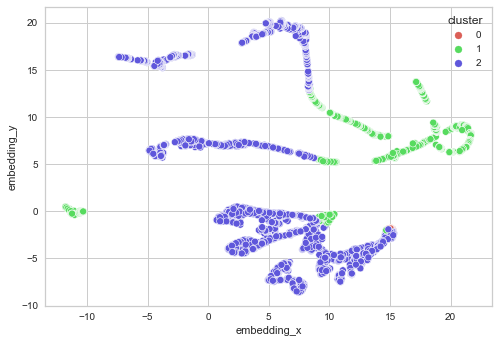

In [179]:
# instantiate UMAP
reducer = umap.UMAP(n_neighbors=20, random_state=42)

# transform data space into embedding
embedding = reducer.fit_transform(x)

# define x and y and save on df_viz dataset
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

## Cluster Profile

In [180]:
# Number of customers
df_cluster = df8[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross Revenue
df_gross_revenue = df8[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_recency_days = df8[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# Avg Frequency
df_frequency = df8[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Avg TIcket
df_ticket = df8[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,22,0.508083,10.335114,-0.722419,8.441036,4.189468
1,1,1086,25.080831,-0.164555,1.538960,-0.350287,-0.008679
2,2,3222,74.411085,-0.015104,-0.513786,0.060431,-0.025681


###  Cluster 01:  ( Candidatos Insider )
- Número de customers: 6 (0.14% do customers )
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:
- Número de customers: 31 (0.71 do customers )
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:
- Número de customers: 4.335 (99% do customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

# Deploy